# Object Pointing and Counting


In this example, you will learn how to perform object pointing and counting using the MLX-VLM (Vision Language Model) library. 

We will use `Molmo2-4B`, for pointing and counting objects in images.

## Installation


In [ ]:
pip install -U mlx-vlm

## Import Dependencies

In [12]:
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from mlx_vlm import apply_chat_template, load, generate
from mlx_vlm.utils import load_image


## Helpers

In [20]:

def parse_points_from_output(model_output: str):
    """Extract point coordinates from Molmo-style outputs.

    Molmo2 format: <points coords="ID X Y ID X Y ..."/>
    where X and Y are 3-4 digit numbers on a 0-1000 scale.
    """
    coords_match = re.search(r'<points[^>]*coords="([^"]+)"', model_output)
    if coords_match:
        coords_str = coords_match.group(1)

        # Molmo2 format: "ID X Y" where X,Y are 3-4 digits (0-1000 scale)
        # The regex ensures we correctly parse the format and skip metadata
        MOLMO2_POINTS_REGEX = re.compile(r"([0-9]+) ([0-9]{3,4}) ([0-9]{3,4})")
        points = []
        for match in MOLMO2_POINTS_REGEX.finditer(coords_str):
            x, y = float(match.group(2)), float(match.group(3))
            points.append((x, y))

        if points:
            return points

        # Fallback: try parsing as simple number pairs
        numbers = [float(n) for n in re.findall(r"-?\d+(?:\.\d+)?", coords_str)]
        if not numbers:
            return []
        if len(numbers) % 2 == 1:
            numbers = numbers[1:]  # Skip leading ID if odd count
        return [(numbers[i], numbers[i + 1]) for i in range(0, len(numbers) - 1, 2)]

    # Legacy format: <points x1="..." y1="..." x2="..." y2="..."/>
    tag_match = re.search(r"<points[^>]*>", model_output)
    if not tag_match:
        return []

    tag = tag_match.group(0)
    if 'x1="' in tag:
        points = []
        i = 1
        while True:
            x_match = re.search(rf'x{i}="([^"]+)"', tag)
            y_match = re.search(rf'y{i}="([^"]+)"', tag)
            if not x_match or not y_match:
                break
            points.append((float(x_match.group(1)), float(y_match.group(1))))
            i += 1
        return points
    if 'x="' in tag and 'y="' in tag:
        x_match = re.search(r'x="([^"]+)"', tag)
        y_match = re.search(r'y="([^"]+)"', tag)
        if x_match and y_match:
            return [(float(x_match.group(1)), float(y_match.group(1)))]

    return []


def scale_points_to_image(points, image: Image.Image):
    """Scale points to image size based on common Molmo coordinate ranges."""
    if not points:
        return []
    w, h = image.size
    max_value = max(max(x for x, _ in points), max(y for _, y in points))
    if max_value <= 1.0:
        scale = 1.0
    elif max_value <= 100.0:
        scale = 100.0
    elif max_value <= 1000.0:
        scale = 1000.0
    else:
        # Already in pixel coordinates
        return points
    return [(x * w / scale, y * h / scale) for x, y in points]


def draw_points_on_image(image: Image.Image, model_output: str):
    """Parse Molmo point output and draw points on the image."""
    points = parse_points_from_output(model_output)
    if not points:
        print("No points found in output")
        return

    scaled_points = scale_points_to_image(points, image)
    w, h = image.size

    # Draw points
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    radius = max(10, min(w, h) // 50)

    for x, y in scaled_points:
        draw.ellipse([x - radius, y - radius, x + radius, y + radius],
                     fill='red', outline='white', width=3)

    # Show with matplotlib
    plt.figure(figsize=(12, 10))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def resize_if_needed(image: Image.Image, max_dimension: int = 2000) -> Image.Image:
    """Resize image if it exceeds max_dimension to improve model accuracy.

    Very large images (>10MP) get heavily downsampled during preprocessing,
    which can reduce coordinate precision. Pre-resizing helps maintain accuracy.
    """
    w, h = image.size
    if max(w, h) <= max_dimension:
        return image

    ratio = max_dimension / max(w, h)
    new_size = (int(w * ratio), int(h * ratio))
    print(f"Resizing image from {w}x{h} to {new_size[0]}x{new_size[1]} for better accuracy")
    return image.resize(new_size, Image.Resampling.LANCZOS)



## Molmo2

In [21]:
# Load model and processor
# Test with converted Molmo2-8B (8-bit quantized)

model, processor = load("Aliyovic/molmo2-4b-mlx-8bit")
config = model.config


Fetching 20 files: 100%|██████████| 20/20 [00:00<00:00, 18436.50it/s]


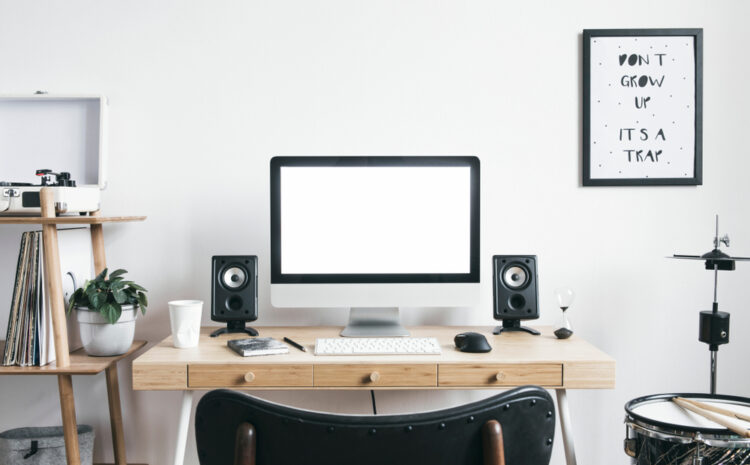

In [22]:
# Load image
image = "images/desktop_setup.png"
image = load_image(image)
image

## Point to all objects

In [23]:
# Test with descriptive prompt (improves accuracy for small elements)
messages = [
    {
        "role": "user",
        "content": "locate all speakers",
    }
]
prompt = apply_chat_template(processor, config, messages, num_images=1)

In [24]:
output = generate(model, processor, prompt, [image], max_tokens=100)

In [6]:
print(output)

 <points x1="32.0" y1="62.8" x2="68.5" y2="62.8" alt="speakers">speakers</points>


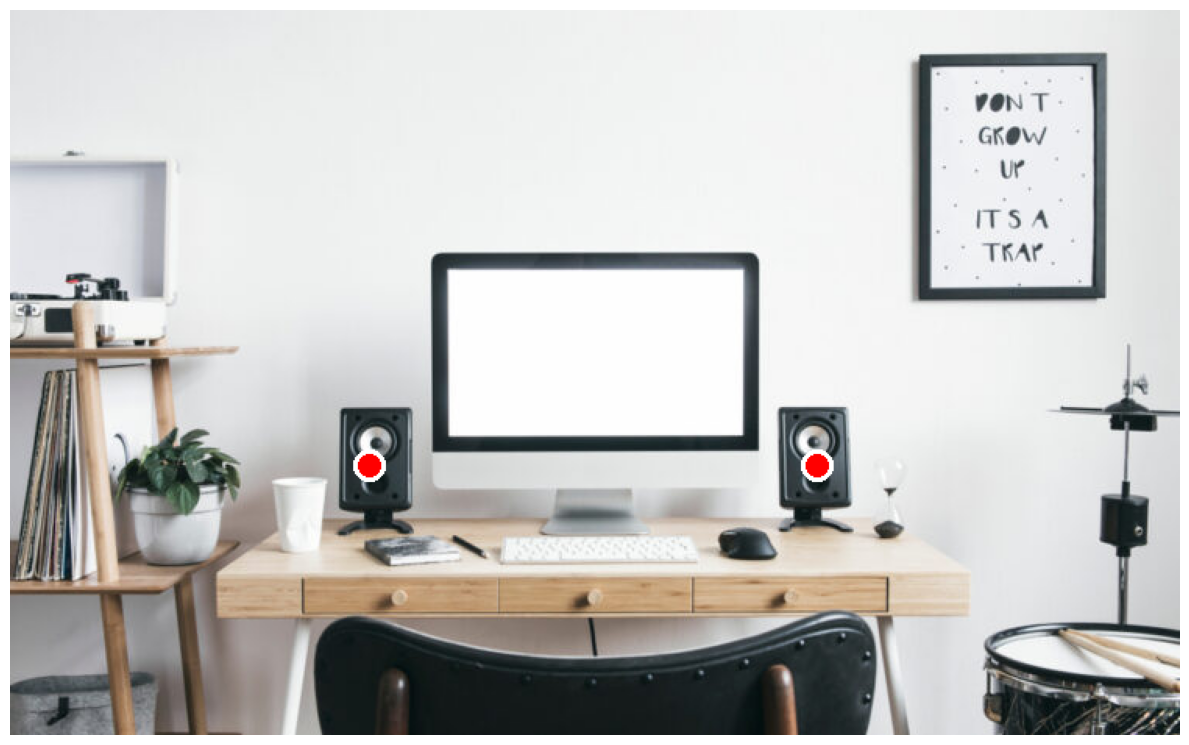

In [25]:
# Draw the point on the original image (scale coordinates back if resized)
draw_points_on_image(image, output.text)